## China

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

START_YEAR, END_YEAR = 1960, 2023
DIP_WINDOW = (1978, 1988)

CHINA_NAME = "China"
CHINA_CODE = "CHN"

REGIONS = {
    "World": "WLD",
    "Low income": "LIC",
    "East Asia & Pacific": "EAS",
    "South Asia": "SAS",
    "Middle East & North Africa": "MEA",
    "Sub-Saharan Africa": "SSF",
    "Europe & Central Asia": "ECS",
    "Latin America & Caribbean": "LCN",
    "North America": "NAC",
}

REFORM_PERIODS = {
    "Great Leap Forward": (1958, 1962),
    "Post-Mao Transition": (1976, 1978),
    "Reform Era Start": (1978, 1992),
    "WTO Entry": (2001, 2005),
    "One-Child Policy": (1980, 2015),
}

INDICATORS = {
    "NY.GDP.MKTP.CD": "gdp",
    "NY.GDP.PCAP.CD": "gdp_percap",
    "SP.DYN.TFRT.IN": "fertility",
    "SP.POP.TOTL": "pop",
    "SP.POP.GROW": "pop_growth",
    "NV.AGR.TOTL.ZS": "ag_va",
    "SE.PRM.ENRR": "edu_prim",
}

In [12]:
def wb_fetch_series(code: str, indicator: str, start=START_YEAR, end=END_YEAR, timeout=180) -> pd.DataFrame:
    url = (
        f"https://api.worldbank.org/v2/country/{code}/indicator/{indicator}"
        f"?format=json&per_page=20000&date={start}:{end}"
    )
    r = requests.get(url, timeout=timeout, headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()
    payload = r.json()

    if not isinstance(payload, list) or len(payload) < 2 or payload[1] is None:
        return pd.DataFrame({"year": [], "value": []})

    rows = []
    for item in payload[1]:
        year = int(item["date"])
        val = item["value"]
        rows.append((year, np.nan if val is None else float(val)))

    return pd.DataFrame(rows, columns=["year", "value"]).sort_values("year")


def wb_fetch_table(code: str, indicators: dict, start=START_YEAR, end=END_YEAR) -> pd.DataFrame:
    out = pd.DataFrame({"year": list(range(start, end + 1))})
    for ind_code, col in indicators.items():
        s = wb_fetch_series(code, ind_code, start, end).rename(columns={"value": col})
        out = out.merge(s[["year", col]], on="year", how="left")
    return out


def dip_score(years: pd.Series, series: pd.Series, window=DIP_WINDOW) -> float:
    w0, w1 = window
    in_w = (years >= w0) & (years <= w1)
    pre = (years >= (w0 - 5)) & (years <= (w0 - 1))

    if series[in_w].dropna().empty or series[pre].dropna().empty:
        return float("nan")

    pre_mean = float(series[pre].mean())
    w_min = float(series[in_w].min())
    return pre_mean - w_min


def plot_regions_metric(regions_data: dict, col: str, title: str):
    plt.figure(figsize=(11, 5))
    for name, df in regions_data.items():
        plt.plot(df["year"], df[col], label=name)
    plt.axvspan(DIP_WINDOW[0], DIP_WINDOW[1], alpha=0.15)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(col)
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()  
    plt.close()


def plot_china_with_periods(df: pd.DataFrame, col: str, title: str):
    plt.figure(figsize=(11, 5))
    plt.plot(df["year"], df[col])

    for label, (a, b) in REFORM_PERIODS.items():
        left = max(a, START_YEAR)
        right = min(b, END_YEAR)
        if left <= right:
            plt.axvspan(left, right, alpha=0.10)

    plt.axvspan(DIP_WINDOW[0], DIP_WINDOW[1], alpha=0.15)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()  
    plt.close()


AGE_BINS = [
    ("0-4", "0004"), ("5-9", "0509"), ("10-14", "1014"), ("15-19", "1519"),
    ("20-24", "2024"), ("25-29", "2529"), ("30-34", "3034"), ("35-39", "3539"),
    ("40-44", "4044"), ("45-49", "4549"), ("50-54", "5054"), ("55-59", "5559"),
    ("60-64", "6064"), ("65-69", "6569"), ("70-74", "7074"), ("75-79", "7579"),
    ("80+", "80UP"),
]


def age_indicator(sex: str, bin_code: str) -> str:
    if bin_code == "80UP":
        return f"SP.POP.80UP.{sex}.IN"
    return f"SP.POP.{bin_code}.{sex}.IN"


def wb_value(code: str, indicator: str, year: int, timeout=180):
    df = wb_fetch_series(code, indicator, start=year, end=year, timeout=timeout)
    if df.empty or df["value"].dropna().empty:
        return np.nan
    return float(df["value"].iloc[0])

def build_population_pyramid_3band(code: str, year: int) -> pd.DataFrame:
    pop_total = wb_value(code, "SP.POP.TOTL", year)

    male_pct = wb_value(code, "SP.POP.TOTL.MA.ZS", year) / 100.0
    fem_pct  = wb_value(code, "SP.POP.TOTL.FE.ZS", year) / 100.0

    a0_14  = wb_value(code, "SP.POP.0014.TO.ZS", year) / 100.0
    a15_64 = wb_value(code, "SP.POP.1564.TO.ZS", year) / 100.0
    a65p   = wb_value(code, "SP.POP.65UP.TO.ZS", year) / 100.0

    rows = [
        {"age": "0–14",  "male": pop_total * a0_14  * male_pct, "female": pop_total * a0_14  * fem_pct},
        {"age": "15–64", "male": pop_total * a15_64 * male_pct, "female": pop_total * a15_64 * fem_pct},
        {"age": "65+",   "male": pop_total * a65p   * male_pct, "female": pop_total * a65p   * fem_pct},
    ]
    return pd.DataFrame(rows)


def plot_population_pyramid(pyr: pd.DataFrame, title: str):
    df = pyr.dropna(subset=["male", "female"]).copy()
    df["male_left"] = -df["male"]

    y = np.arange(len(df["age"]))
    plt.figure(figsize=(8, 5))
    plt.barh(y, df["male_left"], label="Male")
    plt.barh(y, df["female"], label="Female")
    plt.yticks(y, df["age"])
    plt.axvline(0, linewidth=1)

    xmax = max(df["male"].max(), df["female"].max())
    plt.xlim(-xmax * 1.1, xmax * 1.1)

    plt.title(title)
    plt.xlabel("Population")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
regions_data = {}
region_scores = []

for name, code in REGIONS.items():
    df = wb_fetch_table(code, {"SP.POP.GROW": "pop_growth", "SP.DYN.TFRT.IN": "fertility"})
    regions_data[name] = df
    score = dip_score(df["year"], df["pop_growth"])
    region_scores.append((name, code, score))

region_scores = sorted(region_scores, key=lambda x: (-(x[2] if pd.notna(x[2]) else -1e18)))
worst_region_name, worst_region_code, worst_region_score = region_scores[0]

worst_region_name, worst_region_code, worst_region_score


('Low income', 'LIC', 0.7661896012774081)

In [14]:
regions_data = {}
region_scores = []

for name, code in REGIONS.items():
    df = wb_fetch_table(code, {"SP.POP.GROW": "pop_growth", "SP.DYN.TFRT.IN": "fertility"})
    regions_data[name] = df
    score = dip_score(df["year"], df["pop_growth"])
    region_scores.append((name, code, score))

region_scores = sorted(region_scores, key=lambda x: (-(x[2] if pd.notna(x[2]) else -1e18)))
worst_region_name, worst_region_code, worst_region_score = region_scores[0]

worst_region_name, worst_region_code, worst_region_score


('Low income', 'LIC', 0.7661896012774081)

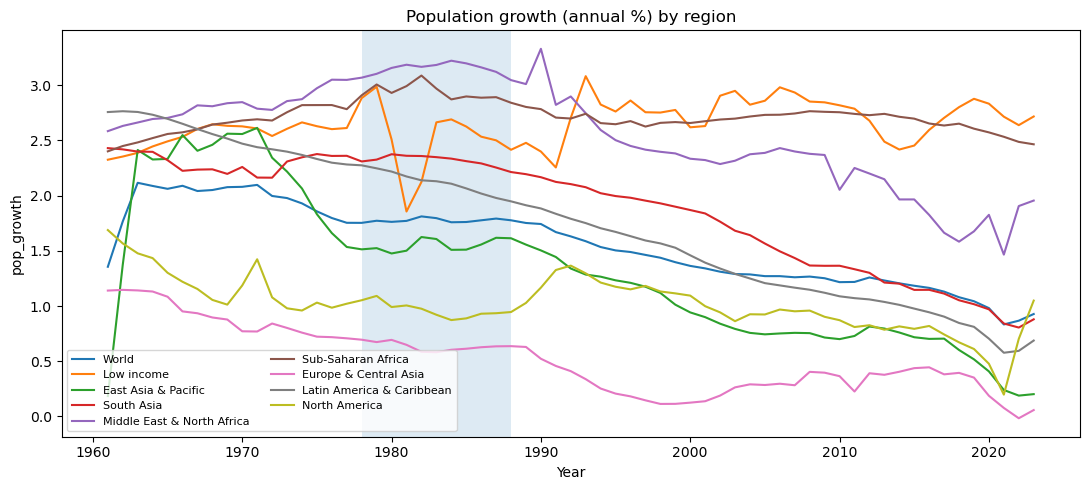

In [15]:
plot_regions_metric(
    regions_data,
    "pop_growth",
    "Population growth (annual %) by region"
)

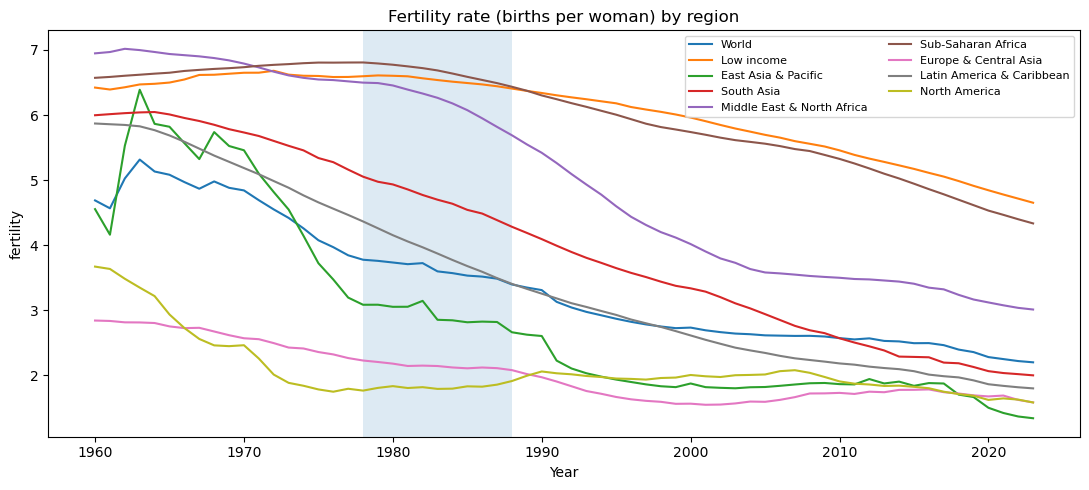

In [16]:
plot_regions_metric(
    regions_data,
    "fertility",
    "Fertility rate (births per woman) by region"
)

In [17]:
china_df = wb_fetch_table(CHINA_CODE, INDICATORS)
china_df.head()

,year,gdp,gdp_percap,fertility,pop,pop_growth,ag_va,edu_prim
0,1960,5.984624e+10,89.715075,4.451,667070000.0,NaN,23.124958,NaN
1,1961,5.016230e+10,75.965501,3.863,660330000.0,-1.015528,35.719491,NaN
2,1962,4.731074e+10,71.061685,6.085,665770000.0,0.820456,38.902722,NaN
3,1963,5.081223e+10,74.468154,7.513,682335000.0,2.457647,39.771365,NaN
4,1964,5.982186e+10,85.661107,6.672,698355000.0,2.320683,37.957493,NaN


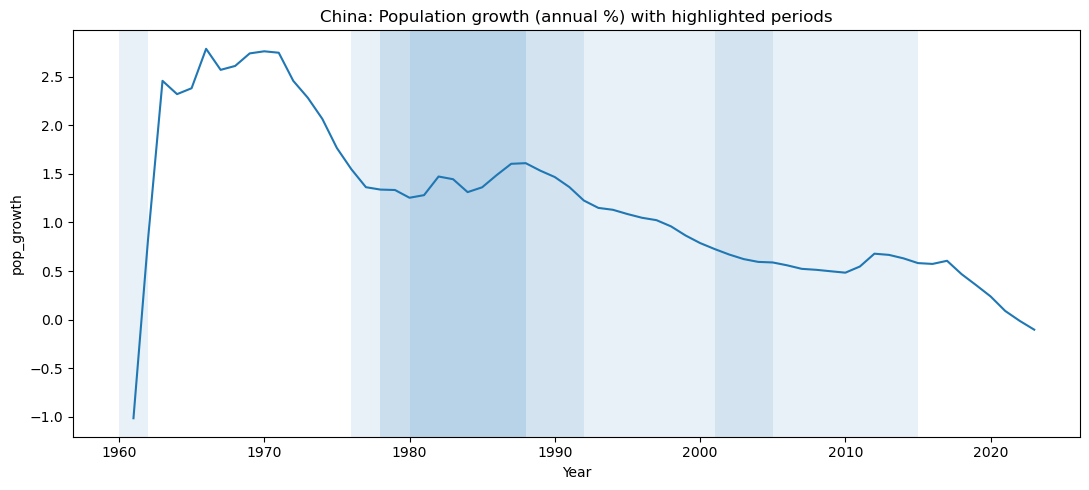

In [18]:
plot_china_with_periods(
    china_df,
    "pop_growth",
    "China: Population growth (annual %) with highlighted periods"
)

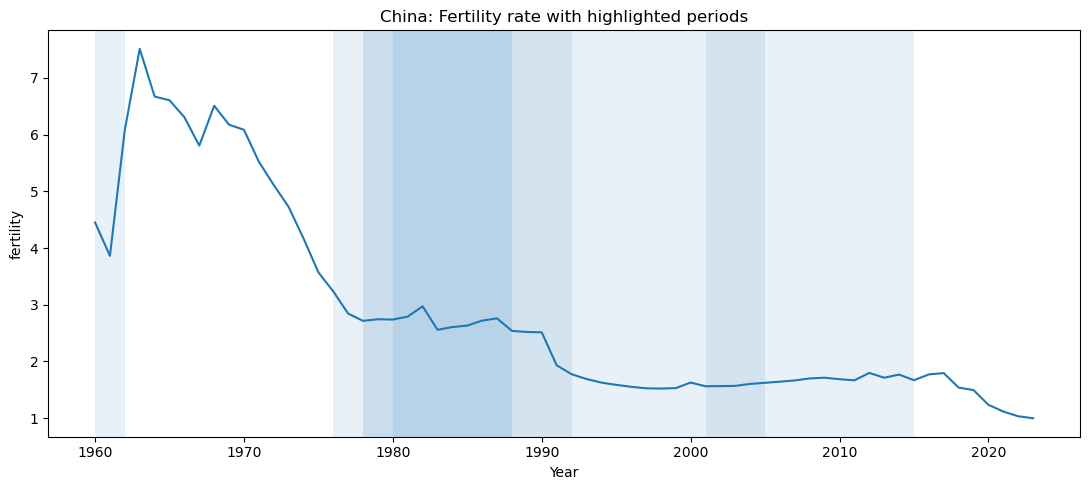

In [19]:
plot_china_with_periods(
    china_df,
    "fertility",
    "China: Fertility rate with highlighted periods"
)

In [22]:
pyramid_year = 1982
pyr = build_population_pyramid_3band("CHN", pyramid_year)
pyr


,age,male,female
0,0–14,1.758646e+08,1.696761e+08
1,15–64,3.139830e+08,3.029343e+08
2,65+,2.349946e+07,2.267254e+07


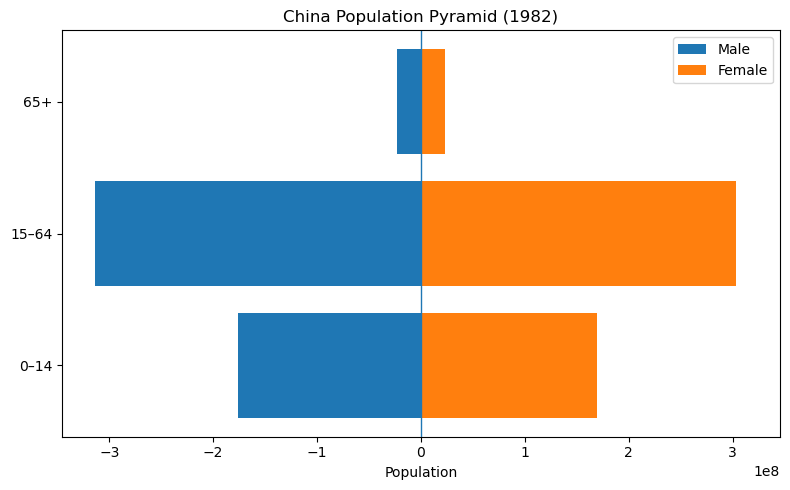

In [23]:
plot_population_pyramid(pyr, f"China Population Pyramid ({pyramid_year})")